In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM2.5_aeroequal_and_council.csv')
data.head()

,Datetime,PM2.5_mg/m³_aeroequal,PM2.5_µg/m³_council
0,2024-08-15 15:00:00,0.566667,4.8
1,2024-08-15 16:00:00,0.733333,3.8
2,2024-08-15 17:00:00,0.633333,7.1
3,2024-08-15 18:00:00,0.566667,6.4
4,2024-08-16 11:00:00,0.777778,3.8


In [3]:
X = data[['PM2.5_mg/m³_aeroequal']].values
y = data['PM2.5_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[0.9       ],
       [1.83928571],
       [0.83333333],
       [2.91666667],
       [0.28333333]])

array([[ 0.36321468],
       [ 2.05730277],
       [ 0.24297522],
       [ 4.00045831],
       [-0.74900031]])

array([[0.73333333],
       [1.2       ],
       [0.21212121],
       [0.66666667],
       [0.77777778]])

array([[ 0.06261604],
       [ 0.90429225],
       [-0.87743791],
       [-0.05762342],
       [ 0.14277567]])

#### Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
Test RMSE: 2.0106
Test MSE: 4.0423
Test R2: 0.4408
Test MAE: 1.6078


,Actual,Predicted
0,6.3,5.975695
1,5.0,7.688447
2,4.3,4.062752
3,4.4,5.731016
4,3.8,6.138814
5,6.3,3.590077
6,4.0,4.446453
7,5.9,5.853356
8,6.3,6.648562
9,7.4,4.935810


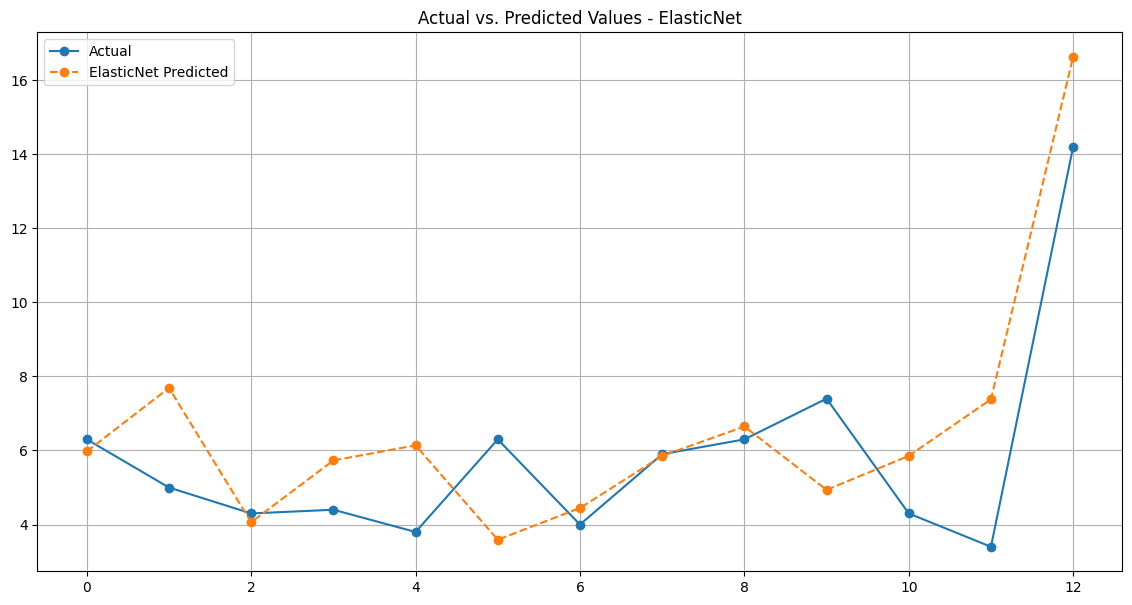


Results For Model: ElasticNet
Best Hyperparameters: {'lasso__alpha': 0.1, 'poly__degree': 1}
Test RMSE: 2.0950
Test MSE: 4.3892
Test R2: 0.3928
Test MAE: 1.6732


,Actual,Predicted
0,6.3,5.981527
1,5.0,7.772676
2,4.3,3.981024
3,4.4,5.725649
4,3.8,6.152113
5,6.3,3.486714
6,4.0,4.382288
7,5.9,5.853588
8,6.3,6.685193
9,7.4,4.894044


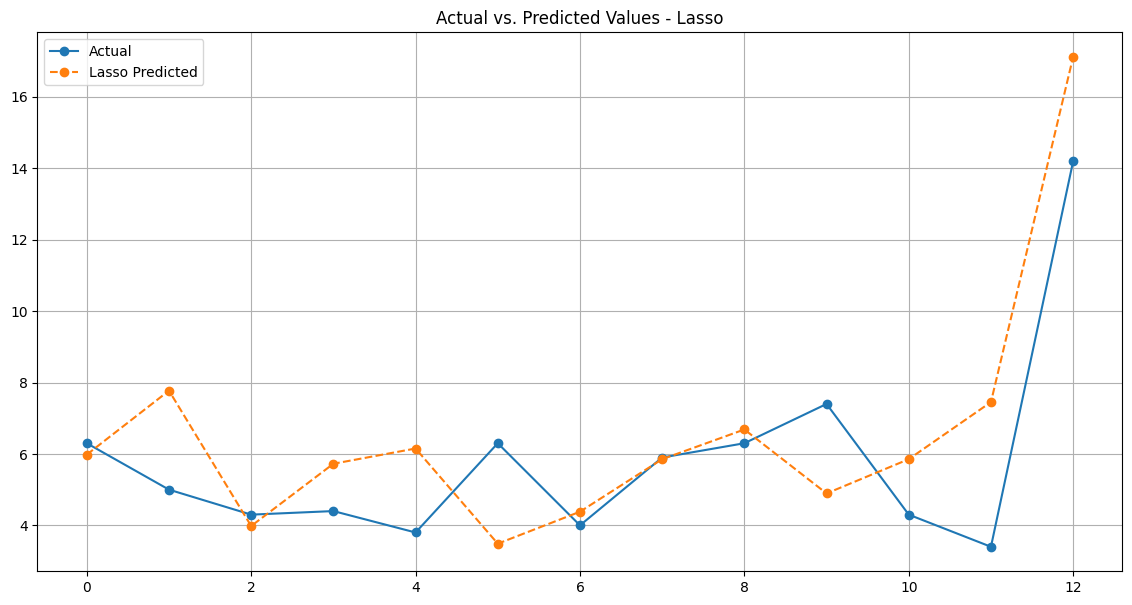


Results For Model: Lasso
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 100}
Test RMSE: 2.0962
Test MSE: 4.3942
Test R2: 0.3921
Test MAE: 1.8195


,Actual,Predicted
0,6.3,5.062548
1,5.0,7.964160
2,4.3,3.180183
3,4.4,5.923010
4,3.8,5.022382
5,6.3,4.008583
6,4.0,5.661517
7,5.9,5.082548
8,6.3,7.218001
9,7.4,4.669179


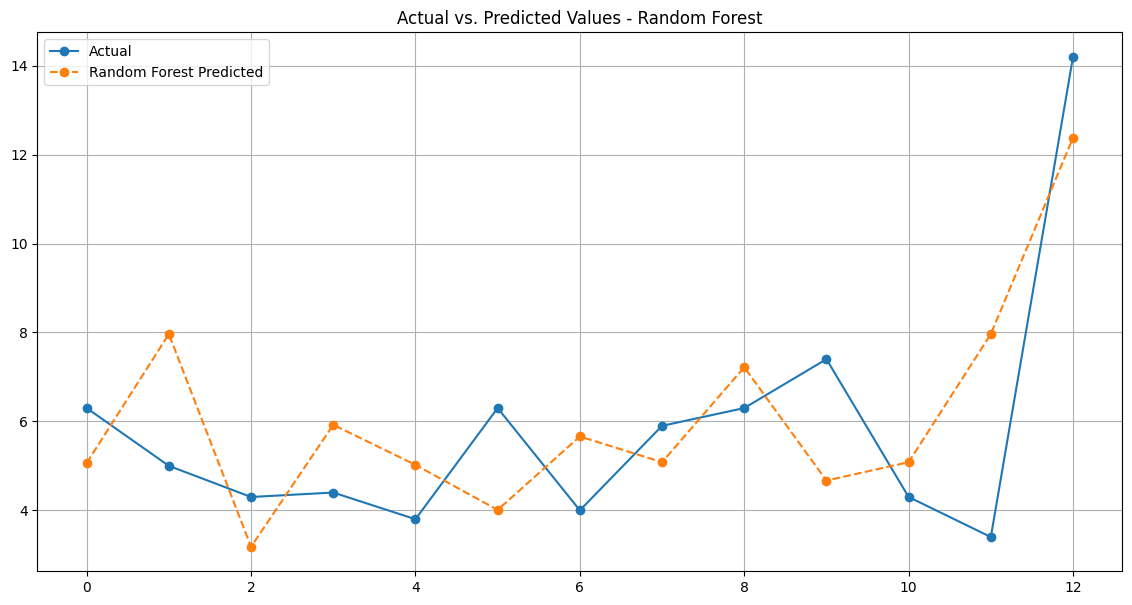


Results For Model: Random Forest
Best Hyperparameters: {'poly__degree': 1, 'ridge__alpha': 0.1}
Test RMSE: 2.1853
Test MSE: 4.7757
Test R2: 0.3394
Test MAE: 1.7380


,Actual,Predicted
0,6.3,5.987310
1,5.0,7.856181
2,4.3,3.899998
3,4.4,5.720328
4,3.8,6.165297
5,6.3,3.384238
6,4.0,4.318674
7,5.9,5.853819
8,6.3,6.721509
9,7.4,4.852637


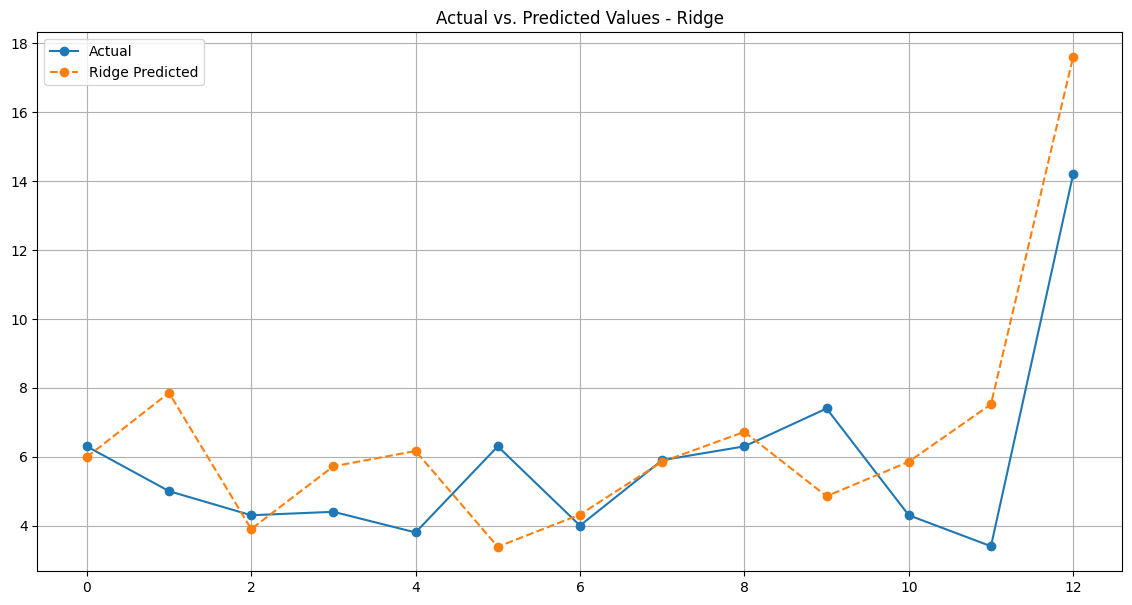


Results For Model: Ridge
Best Hyperparameters: {'gradientboosting__learning_rate': 0.01, 'gradientboosting__max_depth': 3, 'gradientboosting__n_estimators': 50}
Test RMSE: 2.1917
Test MSE: 4.8036
Test R2: 0.3355
Test MAE: 1.7190


,Actual,Predicted
0,6.3,5.628226
1,5.0,7.290685
2,4.3,5.059708
3,4.4,5.628226
4,3.8,5.628226
5,6.3,5.059708
6,4.0,5.686795
7,5.9,5.628226
8,6.3,6.181323
9,7.4,5.499664


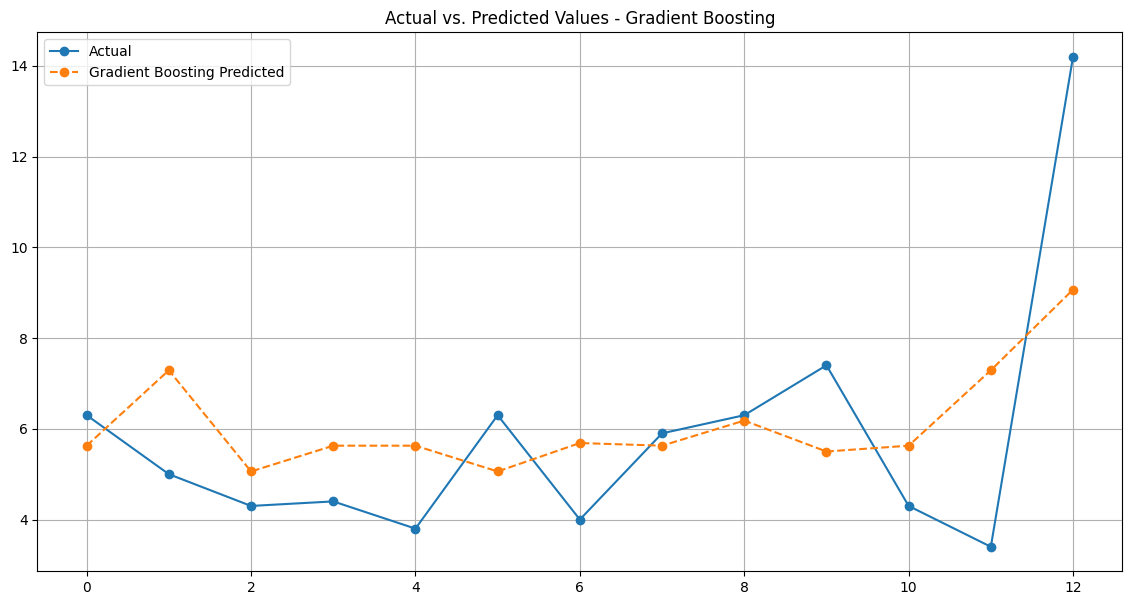


Results For Model: Gradient Boosting
Best Hyperparameters: {'poly__degree': 1}
Test RMSE: 2.1931
Test MSE: 4.8096
Test R2: 0.3347
Test MAE: 1.7433


,Actual,Predicted
0,6.3,5.987789
1,5.0,7.863105
2,4.3,3.893280
3,4.4,5.719887
4,3.8,6.166390
5,6.3,3.375742
6,4.0,4.313400
7,5.9,5.853838
8,6.3,6.724520
9,7.4,4.849204


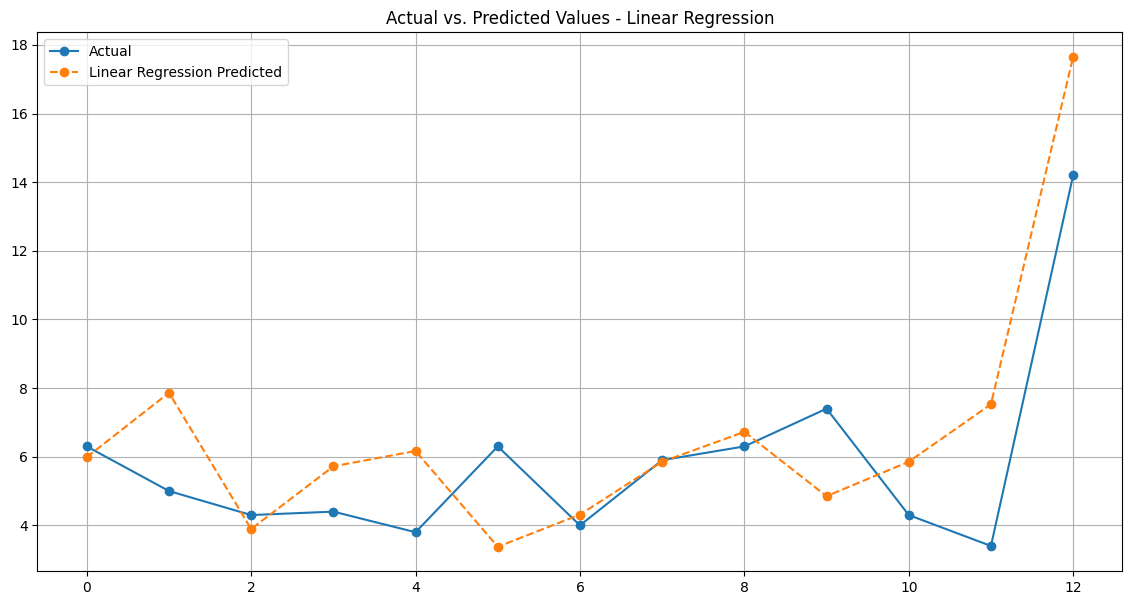


Results For Model: Linear Regression
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 5, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'uniform'}
Test RMSE: 2.2315
Test MSE: 4.9797
Test R2: 0.3112
Test MAE: 1.7569


,Actual,Predicted
0,6.3,4.40
1,5.0,8.28
2,4.3,3.96
3,4.4,4.58
4,3.8,6.58
5,6.3,3.96
6,4.0,4.10
7,5.9,4.58
8,6.3,7.08
9,7.4,5.86


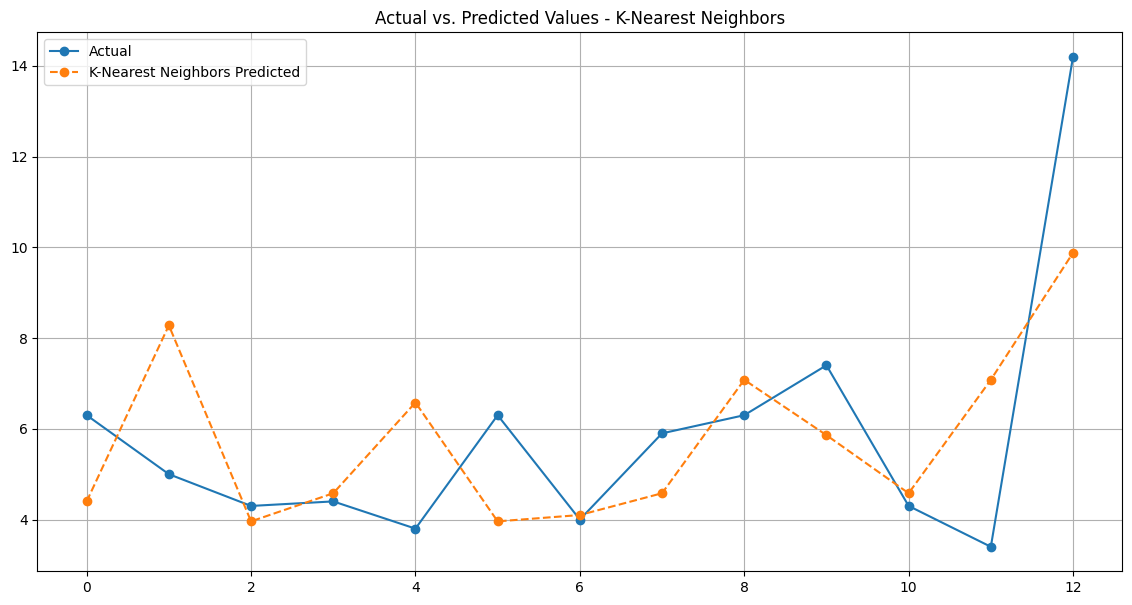


Results For Model: K-Nearest Neighbors
Best Hyperparameters: {'adaboost__learning_rate': 0.01, 'adaboost__loss': 'linear', 'adaboost__n_estimators': 50}
Test RMSE: 2.3967
Test MSE: 5.7442
Test R2: 0.2054
Test MAE: 1.6872


,Actual,Predicted
0,6.3,4.900000
1,5.0,9.500000
2,4.3,3.633333
3,4.4,4.983333
4,3.8,4.900000
5,6.3,4.050000
6,4.0,4.433333
7,5.9,4.900000
8,6.3,6.900000
9,7.4,4.900000


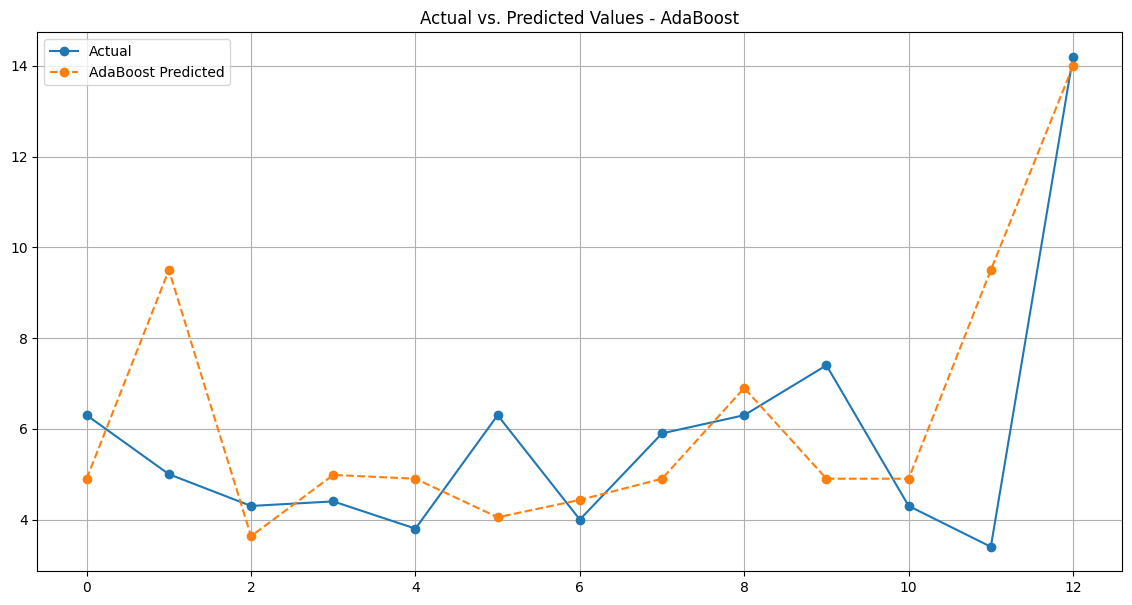


Results For Model: AdaBoost
Best Hyperparameters: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.6}
Test RMSE: 2.5592
Test MSE: 6.5494
Test R2: 0.0940
Test MAE: 1.8959


,Actual,Predicted
0,6.3,5.135780
1,5.0,9.255995
2,4.3,4.208135
3,4.4,5.428165
4,3.8,5.135780
5,6.3,4.208135
6,4.0,3.867066
7,5.9,5.428165
8,6.3,6.917088
9,7.4,4.972444


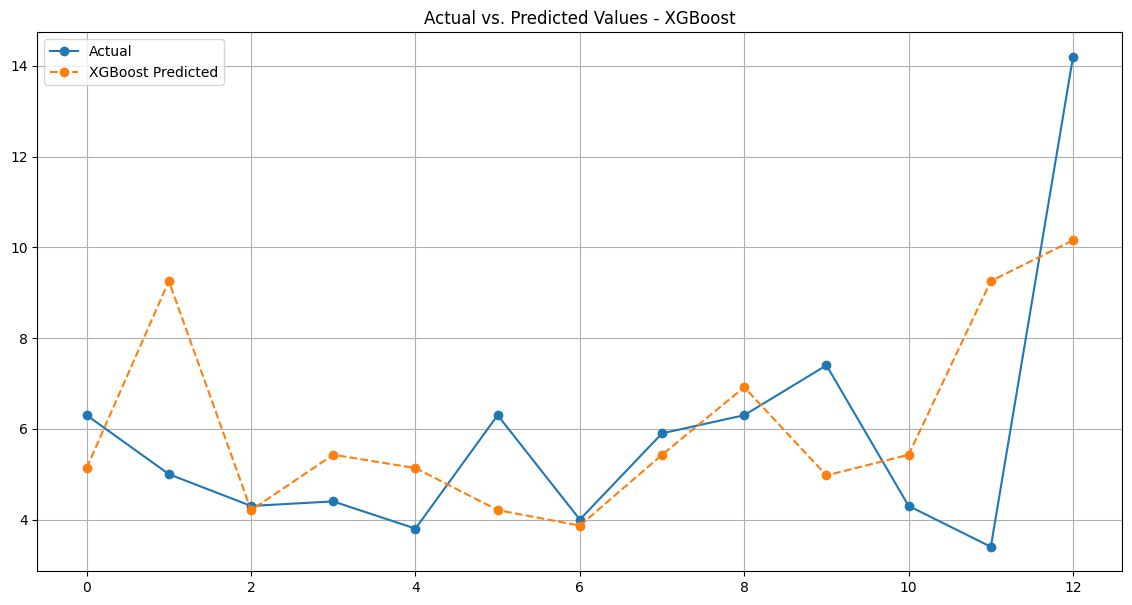

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,ElasticNet,2.010556,4.042334,0.440817,1.607838
1,Lasso,2.095045,4.389214,0.392832,1.673177
2,Random Forest,2.096239,4.394218,0.392140,1.819518
3,Ridge,2.185337,4.775698,0.339369,1.737954
4,Gradient Boosting,2.191713,4.803605,0.335509,1.719019
5,Linear Regression,2.193091,4.809647,0.334673,1.743325
6,K-Nearest Neighbors,2.231522,4.979692,0.311150,1.756923
7,AdaBoost,2.396712,5.744231,0.205390,1.687179
8,XGBoost,2.559170,6.549354,0.094016,1.895933
